# Crack detection

* Crack detection has vital importance for structural health monitoring and inspection.
* I denote images of cracked concrete as the positive class and images of concrete with no cracks as the negative class.

## Method 1 : **resnet18**
* Download Data

In [0]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
!unzip -q Positive_tensors.zip 

--2020-03-02 20:53:54--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  35.2MB/s    in 72s     

2020-03-02 20:55:06 (34.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [0]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2020-03-02 20:58:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  35.8MB/s    in 58s     

2020-03-02 20:59:11 (34.8 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [0]:
!pip install torchvision
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow
from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0) #The torch.manual_seed() is for forcing the random function to give the same number every time when  try to recompile it.

* Dataset Class

In [0]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    


In [0]:
dataset_train = Dataset(train=True)
dataset_vald = Dataset(train=False)

In [0]:
# Step 1: Load the pre-trained model resnet18
model = models.resnet18(pretrained=True)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

resnet18 is used to classify 1000 different objects; as a result, the last layer has 1000 outputs. The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


In [0]:
#Step 3: Replace the output layer model.re of the neural network with a nn.Linear object,
#to classify 2 different classes. For the parameters in_features remember the last hidden layer has 512 neurons.
model.fc = nn.Linear(512, 7)

In [0]:
# Create the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_vald, batch_size=10)

In [0]:
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=1):
  epochs=1
  loss_list=[]
  accuracy_list=[]
  correct=0
  N_test=len(dataset_vald)
  Loss=0
  for epoch in range(epochs):
      for x, y in train_loader:
          model.train() 
          #clear gradient 
          optimizer.zero_grad()
          #make a prediction 
          z = model(x)
          # calculate loss 
          loss = criterion(z, y)
          # calculate gradients of parameters 
          #loss_sublist.append(loss.data.item())
          loss.backward()
          # update parameters 
          optimizer.step()
          loss_list.append(loss.data)
      correct=0
      for x_test, y_test in validation_loader:
          # set model to eval 
          model.eval()
          #make a prediction 
          z = model(x_test)
          #find max 
          _, yhat = torch.max(z.data, 1)
          #Calculate misclassified  samples in mini-batch 
          correct += (yhat==y_test).sum().item()  
    
      accuracy=correct/N_test
  print(accuracy)
training_results_Norm=train(model , criterion, train_loader, validation_loader, optimizer, epochs=1)

0.9961


Misclassified samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


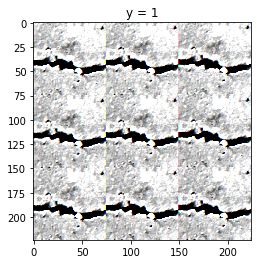

probability of class  0.9897875785827637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


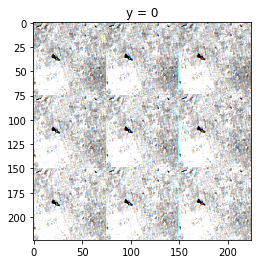

probability of class  0.9573458433151245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


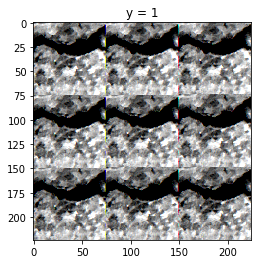

probability of class  0.9702693223953247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


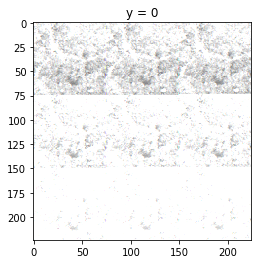

probability of class  0.8052184581756592


In [0]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(224, 224, 3), cmap='coolwarm')
    plt.title('y = ' + str(data_sample[1].item()))
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in dataset_vald:
    z = model(x.reshape(224, 3, 32, 7))
    yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        #print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 4:
        break

In [0]:
sampleSeq=0
N_samples=0

for x_test, y_test in validation_loader:
    model.eval()
    z=model(x_test)
    _, yhat=torch.max(z.data,1)
    
    for i in range(len(y_test)):
        sampleSeq += 1
        if yhat[i] != y_test[i]:
            print("sample#: %d - predicted value: %d - actual value: %d" % (sampleSeq, yhat[i], y_test[i]))
            N_samples += 1
            if N_samples >= 4:
                break
    if N_samples >=4:
        break

sample#: 95 - predicted value: 0 - actual value: 1
sample#: 321 - predicted value: 0 - actual value: 1
sample#: 342 - predicted value: 1 - actual value: 0
sample#: 871 - predicted value: 0 - actual value: 1


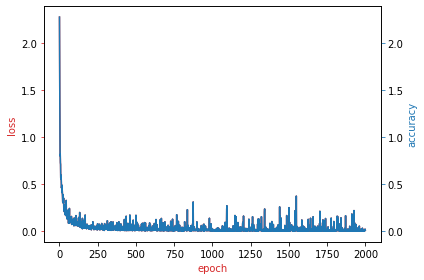

In [0]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( loss_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [0]:
print(accuracy)

0.995
